# Imports

In [65]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [66]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [67]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [68]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [69]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            return list_inc_score.flatten()
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [70]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[5.75683391 5.75831648 5.75684827 ... 1.80856159 5.18975564 1.80886734]
[11.66059284 11.66359582 11.66062193 ...  3.66328101 10.51196341
  3.66390031]
[0.99999877 0.99999877 0.99999877 ... 0.98628247 0.9999953  0.98629224]
(5999,)


### Multinomial Sampling

In [71]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[1 0 0 ... 0 0 0]


In [72]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.02465, -0.66553295, 3.79476), (75.53862, 8.672658, -6.477539), (75.091965, 1.3272538, 3.7590551), (75.0, 3.2518802, 3.177119), (75.16122, 3.2518802, 3.1983433), (75.440445, 3.2518802, 3.3595567), (75.55499, 3.2518802, 3.5172179), (75.27572, 3.8609922, 2.9514337), (75.524445, 3.8609922, 3.0781662), (75.7727, 3.8609922, 3.3538823), (75.65732, 4.4479885, 2.787821), (75.56085, 5.0095077, 2.3389213), (76.04721, 5.0095077, 2.6369581), (76.39445, 5.0095077, 3.0894926), (75.0, 5.5423326, 1.8353895), (39.0, 8.743327, 89.00289), (86.77158, 5.2797017, 91.79918), (81.793236, 6.2811418, 94.53247), (75.0, 8.672658, -6.4916434), (75.0, 8.535009, -7.143274), (75.80706, 5.7970243, -11.59963), (77.53778, -8.114116, -8.139311), (80.526306, -5.7970243, -10.596523), (88.640785, 7.138877, 84.09944), (75.0, 2.3044074, -13.492921), (75.0, -3.5589852, -13.048206), (75.0, -4.7321377, -12.419358), (76.90945, 8.114116, 93.25577), (78.18029, -8.672658, 90.98794), (90.3916, 3.5589852, 88.05278), (63.0, -1.8187

# KNN

In [73]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.02465, -0.66553295, 3.79476], [75.53862, 8.672658, -6.477539], [75.091965, 1.3272538, 3.7590551], [75.0, 3.2518802, 3.177119], [75.16122, 3.2518802, 3.1983433], [75.440445, 3.2518802, 3.3595567], [75.55499, 3.2518802, 3.5172179], [75.27572, 3.8609922, 2.9514337], [75.524445, 3.8609922, 3.0781662], [75.7727, 3.8609922, 3.3538823], [75.65732, 4.4479885, 2.787821], [75.56085, 5.0095077, 2.3389213], [76.04721, 5.0095077, 2.6369581], [76.39445, 5.0095077, 3.0894926], [75.0, 5.5423326, 1.8353895], [39.0, 8.743327, 89.00289], [86.77158, 5.2797017, 91.79918], [81.793236, 6.2811418, 94.53247], [75.0, 8.672658, -6.4916434], [75.0, 8.535009, -7.143274], [75.80706, 5.7970243, -11.59963], [77.53778, -8.114116, -8.139311], [80.526306, -5.7970243, -10.596523], [88.640785, 7.138877, 84.09944], [75.0, 2.3044074, -13.492921], [75.0, -3.5589852, -13.048206], [75.0, -4.7321377, -12.419358], [76.90945, 8.114116, 93.25577], [78.18029, -8.672658, 90.98794], [90.3916, 3.5589852, 88.05278], [63.0, -1.8187

In [74]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [75]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  18


Number of nodes: 50
Number of edges: 682


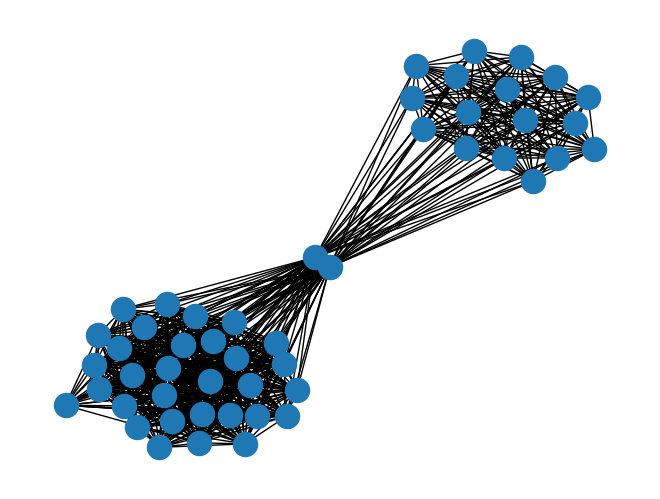

In [76]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [80]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = inclusion_score.reshape((len(extended_graph._node), 64))
print(inclusion_score)
print(inclusion_score.shape)

[[232.7131824  122.37818692 247.28424069 ... 119.4852814  150.22234698
   41.84664955]
 [232.85215359 122.45126847 247.43191339 ... 119.55663538 150.31205646
   41.87163945]
 [ 41.46009407  21.80285229  44.0560684  ...  21.28745332  26.7635575
    7.45538353]
 ...
 [ 30.43218608  16.00354444  32.3376611  ...  15.62523566  19.64475914
    5.47233729]
 [ 24.94019129  13.11543832  26.50179161 ...  12.80540167  16.09953519
    4.48476289]
 [ 36.21106749  19.04251723  38.47838028 ...  18.59236999  23.37517578
    6.51149985]]
(50, 64)


### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh